In [ ]:
!pip install tweet-preprocessor

In [ ]:
# Necessary libraries and modules for data manipulation, preprocessing, and model building
import csv, sys, string, warnings, pickle, xgboost, textblob, nltk, re
import pandas as pd
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import numpy as np
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.preprocessing import text, sequence
from sklearn.multiclass import OneVsRestClassifier
warnings.filterwarnings('ignore')
from nltk.tokenize import TweetTokenizer
from nltk import FreqDist
pd.options.display.max_colwidth = 1000
from gensim.parsing.preprocessing import remove_stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import preprocessor as p
p.set_options(p.OPT.URL)

In [ ]:
# Mounting Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function to load data from TSV file
def getData(file):
    tsv_file = open(file)
    df = pd.read_csv(tsv_file, delimiter="\t")
    return df

# Loading train, validation, and test datasets
trainFilename = "/content/drive/MyDrive/Covid-19-fake-news-detection-main/Covid-19-fake-news-detection-main/Constraint-AI/Data/Constraint_English_Train - Sheet1.tsv" # File path
validFilename = "/content/drive/MyDrive/Covid-19-fake-news-detection-main/Covid-19-fake-news-detection-main/Constraint-AI/Data/Constraint_English_Val - Sheet1.tsv" # File path
testFilename = "/content/drive/MyDrive/Covid-19-fake-news-detection-main/Covid-19-fake-news-detection-main/Constraint-AI/Data/english_test_with_labels - Sheet1.tsv" # File path
trainDF = getData(trainFilename)
validDF = getData(validFilename)
testDF = getData(testFilename)
print("Train Data Shape: ",trainDF.shape)
print("Validation Data Shape: ",validDF.shape)
print("Test Data Shape: ",testDF.shape)

Train Data Shape:  (6420, 3)
Validation Data Shape:  (2140, 3)
Test Data Shape:  (2140, 3)


In [ ]:
# Function to preprocess tweets
def preprocessTweet(row):
    text = row['tweet']
    text = p.clean(text)
    text = text.lower().replace("#", "").replace("@", "")
    return text

# Applying preprocessing to train, validation, and test datasets
trainDF['processedTweet'] = trainDF.apply(preprocessTweet, axis=1)
validDF['processedTweet'] = validDF.apply(preprocessTweet, axis=1)
testDF['processedTweet'] = testDF.apply(preprocessTweet, axis=1)

# Concatenating train and validation data
totalTextData = pd.concat([trainDF['tweet'], validDF['tweet']])

In [ ]:
# Segregating real and fake data
totalData = pd.concat([trainDF, validDF, testDF])
realData = totalData[totalData["label"]=="real"]["processedTweet"]
fakeData = totalData[totalData["label"]=="fake"]["processedTweet"]

In [ ]:
# Positive word cloud generation
positiveCloud = ""
for i in realData:
    i = re.sub(r'\b\w{1,2}\b', '', i)
    i = i.split()
    positiveCloud += " ".join(i)+" "
print(len(positiveCloud))

# Negative word cloud generation
negativeCloud = ""
for i in fakeData:
    i = re.sub(r'\b\w{1,2}\b', '', i)
    i = i.split()
    negativeCloud += " ".join(i)+" "
print(len(negativeCloud))

979329
620900


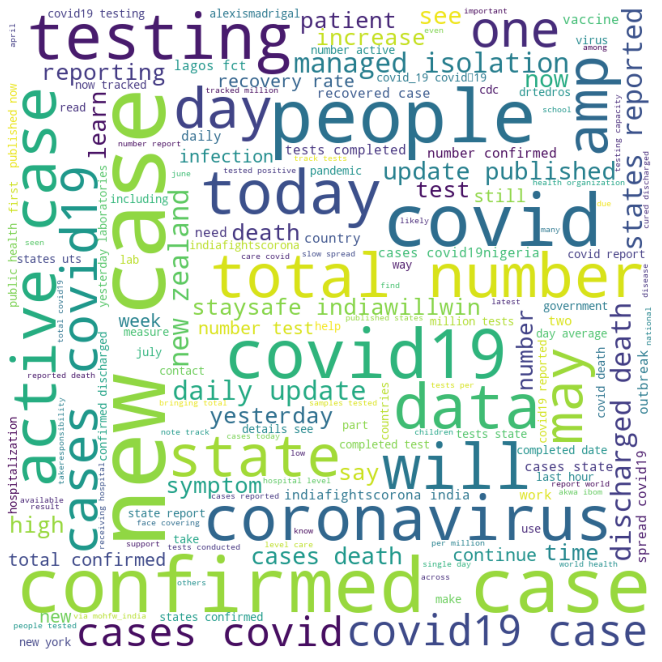

<Figure size 432x288 with 0 Axes>

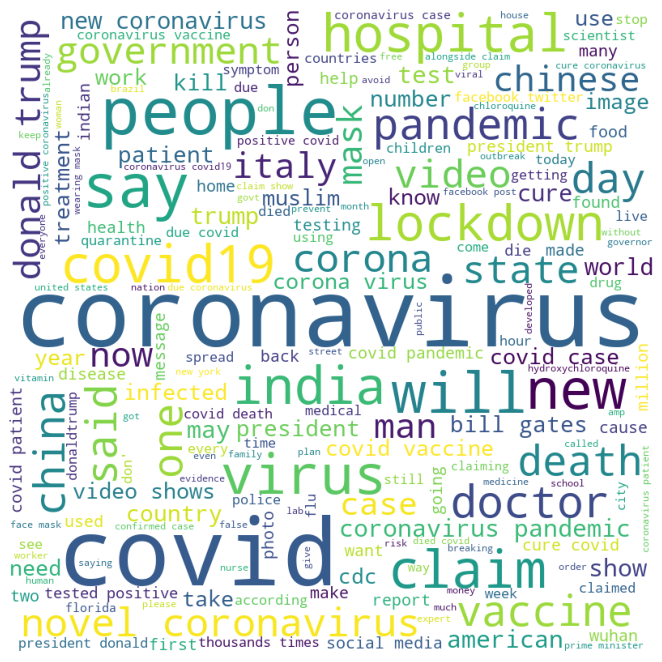

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plotting positive word cloud
stopwords = set(STOPWORDS)
positiveWordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(positiveCloud)
plt.figure(figsize = (10, 9), facecolor = None)
plt.imshow(positiveWordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
plt.savefig('positive.png')

# Plotting negative word cloud
negativeWordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(negativeCloud)

# plot the WordCloud image
plt.figure(figsize = (10, 9), facecolor = None)
plt.imshow(negativeWordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
plt.savefig('negative.png')

In [ ]:
# Evaluating model
file = "/content/drive/MyDrive/Covid-19-fake-news-detection-main/Covid-19-fake-news-detection-main/Constraint-AI/Results/answer_withdev.txt" # File path
data_X = getData(file)
print(data_X.shape)
data_X['label']

print(metrics.accuracy_score(data_X['label'], testDF['label']))
print(metrics.f1_score(data_X['label'], testDF['label'], average='weighted'))
print(classification_report(data_X['label'], testDF['label'], digits=4))

(2140, 2)
0.9813084112149533
0.9813068407626471
              precision    recall  f1-score   support

        fake     0.9824    0.9785    0.9804      1024
        real     0.9804    0.9839    0.9821      1116

    accuracy                         0.9813      2140
   macro avg     0.9814    0.9812    0.9813      2140
weighted avg     0.9813    0.9813    0.9813      2140



In [ ]:
# TF-IDF vectorization at word level
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=15000)
tfidf_vect.fit(totalTextData)
xtrain_tfidf =  tfidf_vect.transform(trainDF['tweet'])
xvalid_tfidf =  tfidf_vect.transform(validDF['tweet'])

# TF-IDF vectorization at ngram level
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=15000)
tfidf_vect_ngram.fit(totalTextData)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(trainDF['tweet'])
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(validDF['tweet'])

# TF-IDF vectorization at character level
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(1,5), max_features=100)
tfidf_vect_ngram_chars.fit(totalTextData)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(totalTextData)
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(validDF['tweet'])
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(testDF['tweet'])

In [ ]:
# Tokenization and padding
lengths = []
for item in totalTextData:
    lengths.append(len(item.split()))
print("Average length of texts: ", sum(lengths)/len(lengths))

# Tokenization
token = text.Tokenizer()
token.fit_on_texts(totalTextData)
word_index = token.word_index

# Padding sequences
input_size=35
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(trainDF['processedTweet']), maxlen=input_size)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(validDF['processedTweet']), maxlen=input_size)

Average length of texts:  26.892873831775702


In [ ]:
# Loading pre-trained word embeddings
embeddings_index = {}
for i, line in enumerate(open('/content/drive/MyDrive/Covid-19-fake-news-detection-main/Covid-19-fake-news-detection-main/Constraint-AI/Data/wiki-news-300d-1M.vec/wiki-news-300d-1M.vec')): # FIle path
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

# Creating token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Saving embeddings to pickle
with open('wordEmbeddingsMatrix.pickle', 'wb') as handle:
    pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Loading embeddings from pickle
with open('wordEmbeddingsMatrix.pickle', 'rb') as handle:
    embedding_matrix = pickle.load(handle)

In [ ]:
# Label Encoding
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(['real','fake'])
trainDF['numericalLabels'] = labelEncoder.transform(trainDF['label'])
validDF['numericalLabels'] = labelEncoder.transform(validDF['label'])

encoder = preprocessing.LabelEncoder()
trainLabels = encoder.fit_transform(trainDF['label'])
trainLabels = [to_categorical(i, num_classes=2) for i in trainLabels]
trainLabels = np.asarray(trainLabels)
print(trainLabels.shape)
validLabels = encoder.fit_transform(validDF['label'])
validLabels = [to_categorical(i, num_classes=2) for i in validLabels]
validLabels = np.asarray(validLabels)
print(validLabels.shape)

(6420, 2)
(2140, 2)


In [ ]:
# Function to train model
def train_model(classifier, feature_vector_train, label, feature_vector_valid, feature_vector_test, epoch=False, is_neural_net=False):
    if is_neural_net:
        classifier.fit(feature_vector_train, label, epochs=epoch)
        predictions = classifier.predict(feature_vector_valid)
        predictions1 = predictions.argmax(axis=-1)
        validLabels1 = validLabels.argmax(axis=-1)
        acc = metrics.accuracy_score(predictions1, validLabels1)
        f1Score = metrics.f1_score(predictions1, validLabels1, average='macro')
        classificationReport = classification_report(predictions1, validLabels1)

    else:
        # fit the training dataset on the classifier
        classifier.fit(feature_vector_train, label)

        # predict the labels on validation dataset
        predictions = classifier.predict(feature_vector_valid)
        validDF['predictedLabel'] = predictions
        test_predictions = classifier.predict(feature_vector_test)
        testDF['predictedLabel'] = test_predictions
        acc = metrics.accuracy_score(test_predictions, testDF['label'])
        f1Score = metrics.f1_score(test_predictions, testDF['label'], average='macro')
        classificationReport = classification_report(test_predictions, testDF['label'], digits=4)

    return acc, f1Score, classificationReport

In [ ]:
newValidDF = testDF[['id', 'predictedLabel']].copy()
newValidDF.rename(columns = {'predictedLabel':'label'}, inplace = True)

np.savetxt('answer1.txt', newValidDF.values, fmt='%s', delimiter=",", header="id,label")

f = open('answer1.txt', 'r')
f = f.readlines()
f1 = open('answer_svmwithoutdev.txt', 'w')
for item in f:
    item = item.rstrip()
    print(item)
    f1.write(item+"\n")

# id,label
1,real
2,fake
3,fake
4,real
5,real
6,real
7,real
8,fake
9,real
10,real
11,fake
12,fake
13,real
14,fake
15,fake
16,fake
17,fake
18,fake
19,real
20,real
21,fake
22,fake
23,real
24,fake
25,real
26,real
27,fake
28,fake
29,real
30,fake
31,fake
32,fake
33,real
34,fake
35,real
36,real
37,real
38,real
39,fake
40,real
41,real
42,fake
43,fake
44,fake
45,fake
46,real
47,real
48,fake
49,fake
50,real
51,fake
52,fake
53,fake
54,fake
55,fake
56,fake
57,real
58,fake
59,real
60,real
61,fake
62,real
63,fake
64,real
65,fake
66,fake
67,real
68,fake
69,real
70,real
71,real
72,fake
73,fake
74,real
75,real
76,real
77,real
78,real
79,fake
80,fake
81,real
82,fake
83,real
84,real
85,real
86,fake
87,real
88,real
89,real
90,fake
91,real
92,fake
93,fake
94,fake
95,fake
96,real
97,fake
98,real
99,real
100,real
101,real
102,fake
103,fake
104,real
105,fake
106,real
107,real
108,real
109,real
110,real
111,real
112,fake
113,real
114,fake
115,real
116,real
117,fake
118,real
119,fake
120,fake
121,real
122,real

In [ ]:
# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy, f1_Score, classReport = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), trainDF['label'], xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ",  accuracy, f1_Score,"\n", classReport)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy, f1_Score, classReport = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), trainDF['label'], xvalid_tfidf_ngram_chars.tocsc())
print("Xgb, CharLevel Vectors: ",  accuracy, f1_Score,"\n", classReport)

In [ ]:
# Training MLP Classifier with various epochs
for i in range(40,55):
    accuracy, f1_Score, classReport = train_model(MLPClassifier(hidden_layer_sizes= (256,), learning_rate_init=0.0001, activation='relu', verbose=True, random_state=1, max_iter=i), xtrain_tfidf_ngram_chars, trainDF['label'], xvalid_tfidf_ngram_chars, xtest_tfidf_ngram_chars)
    print("MLP, WordLevel TF-IDF: ",  accuracy, f1_Score,"\n", classReport)

Iteration 1, loss = 0.65511344
Iteration 2, loss = 0.55498717
Iteration 3, loss = 0.46495883
Iteration 4, loss = 0.39008737
Iteration 5, loss = 0.32990803
Iteration 6, loss = 0.28165034
Iteration 7, loss = 0.24284524
Iteration 8, loss = 0.21128739
Iteration 9, loss = 0.18538673
Iteration 10, loss = 0.16393060
Iteration 11, loss = 0.14592127
Iteration 12, loss = 0.13075963
Iteration 13, loss = 0.11761370
Iteration 14, loss = 0.10635901
Iteration 15, loss = 0.09634314
Iteration 16, loss = 0.08774038
Iteration 17, loss = 0.08007642
Iteration 18, loss = 0.07334565
Iteration 19, loss = 0.06731865
Iteration 20, loss = 0.06191068
Iteration 21, loss = 0.05711950
Iteration 22, loss = 0.05275508
Iteration 23, loss = 0.04881000
Iteration 24, loss = 0.04526325
Iteration 25, loss = 0.04212315
Iteration 26, loss = 0.03921543
Iteration 27, loss = 0.03653368
Iteration 28, loss = 0.03415443
Iteration 29, loss = 0.03197063
Iteration 30, loss = 0.02999023
Iteration 31, loss = 0.02817891
Iteration 32, los

Iteration 44, loss = 0.01432071
MLP, WordLevel TF-IDF:  0.9602803738317757 0.9602019439567231 
               precision    recall  f1-score   support

        fake     0.9608    0.9561    0.9584      1025
        real     0.9598    0.9641    0.9620      1115

    accuracy                         0.9603      2140
   macro avg     0.9603    0.9601    0.9602      2140
weighted avg     0.9603    0.9603    0.9603      2140

Iteration 1, loss = 0.65511344
Iteration 2, loss = 0.55498717


In [ ]:
# Function to create CNN model
def create_cnn(input_size):
    # Add an Input Layer
    input_layer = layers.Input((input_size, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    #embedding_layer = layers.SpatialDropout1D(0.25)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(512, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(128, activation="relu")(pooling_layer)
    #output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(2, activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy')

    return model

# Creating CNN model and training
classifier = create_cnn(input_size)
accuracy, f1_Score, classReport = train_model(classifier, train_seq_x, trainLabels, valid_seq_x, 6, is_neural_net=True)
print("CNN, Glove: ",  accuracy, f1_Score,"\n", classReport)

Epoch 1/6
201/201 [==============================] - 6s 30ms/step - loss: 0.3032
Epoch 2/6
201/201 [==============================] - 6s 27ms/step - loss: 0.1029
Epoch 3/6
201/201 [==============================] - 6s 29ms/step - loss: 0.0305
Epoch 4/6
201/201 [==============================] - 6s 28ms/step - loss: 0.0120
Epoch 5/6
201/201 [==============================] - 6s 27ms/step - loss: 0.0020
Epoch 6/6
201/201 [==============================] - 6s 28ms/step - loss: 5.0401e-04
CNN, Glove:  0.9425233644859813 0.9424192448612753 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1029
           1       0.94      0.95      0.94      1111

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140



In [ ]:
# Function to create RNN-LSTM model
def create_rnn_lstm(input_size):
    # Add an Input Layer
    input_layer = layers.Input((input_size, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    #embedding_layer = layers.SpatialDropout1D(0.25)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(256)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(128, activation="relu")(lstm_layer)
    #output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(2, activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss='categorical_crossentropy')

    return model

classifier = create_rnn_lstm(input_size)
accuracy, f1_Score, classReport = train_model(classifier, train_seq_x, trainLabels, valid_seq_x, 20, is_neural_net=True)
print("RNN-LSTM, Word Embeddings",  accuracy, f1_Score, "\n", classReport)

Epoch 1/20
201/201 [==============================] - 20s 100ms/step - loss: 0.4459
Epoch 2/20
201/201 [==============================] - 21s 104ms/step - loss: 0.2420
Epoch 3/20
201/201 [==============================] - 23s 115ms/step - loss: 0.1691
Epoch 4/20
201/201 [==============================] - 22s 111ms/step - loss: 0.1191
Epoch 5/20
201/201 [==============================] - 21s 106ms/step - loss: 0.0863
Epoch 6/20
201/201 [==============================] - 19s 96ms/step - loss: 0.0543
Epoch 7/20
201/201 [==============================] - 21s 107ms/step - loss: 0.0423
Epoch 8/20
201/201 [==============================] - 22s 109ms/step - loss: 0.0259
Epoch 9/20
201/201 [==============================] - 22s 109ms/step - loss: 0.0141
Epoch 10/20
201/201 [==============================] - 19s 94ms/step - loss: 0.0302
Epoch 11/20
201/201 [==============================] - 19s 93ms/step - loss: 0.0277
Epoch 12/20
201/201 [==============================] - 18s 87ms/step - loss: 